<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Quantitative%20Finance/Deep%20Portfolio/Deep_Optimization_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


# **Crawling Function**

In [3]:
import pandas as pd
import requests
from pandas import json_normalize
from io import BytesIO
import time
from datetime import datetime, timedelta
from functools import reduce
import numpy as np

entrade_headers = {
  'authority': 'services.entrade.com.vn',
  'accept': 'application/json, text/plain, */*',
  'accept-language': 'en-US,en;q=0.9',
  'dnt': '1',
  'origin': 'https://banggia.dnse.com.vn',
  'referer': 'https://banggia.dnse.com.vn/',
  'sec-ch-ua': '"Edge";v="114", "Chromium";v="114", "Not=A?Brand";v="24"',
  'sec-ch-ua-mobile': '?0',
  'sec-ch-ua-platform': '"Windows"',
  'sec-fetch-dest': 'empty',
  'sec-fetch-mode': 'cors',
  'sec-fetch-site': 'cross-site',
  'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1788.0'
}


def convert_date(text, data_type = "%Y-%m-%d"):
    return datetime.strptime(text, data_type)

def price_collector(symbol, start_date='2023-09-25', end_date='2023-10-25',
                    frequency='1D', type='stock', thousand_unit=True,
                    headers=entrade_headers):
    """
    Get historical price data from entrade.com.vn. The unit price is thousand VND.
    Parameters:
    ----------
        symbol (str): ticker of a stock or index. Available indices are: VNINDEX, VN30, HNX, HNX30, UPCOM, VNXALLSHARE, VN30F1M, VN30F2M, VN30F1Q, VN30F2Q
        start_date (str): start date of the historical price data
        end_date (str): end date of the historical price data
        frequency (str): frequency of the historical price data. Default is '1D' (daily), other options are '1' (1 minute), 15 (15 minutes), 30 (30 minutes), '1H' (hourly)
        type (str): stock or index. Default is 'stock'
        thousand_unit (bool): if True, convert open, high, low, close to VND for stock symbols. Default is True
        headers (dict): headers of the request
    Returns:
    pandas.DataFrame with the following format
        | time | open | high | low | close | volume |
        | ----------- | ---- | ---- | --- | ----- | ------ |
        | YYYY-mm-dd  | xxxx | xxxx | xxx | xxxxx | xxxxxx |
    """
    # add one more day to end_date
    end_date = (datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    # convert from_date, to_date to timestamp
    from_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    to_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
    url = f"https://services.entrade.com.vn/chart-api/v2/ohlcs/{type}?from={from_timestamp}&to={to_timestamp}&symbol={symbol}&resolution={frequency}"
    response = requests.request("GET", url, headers=headers)

    if response.status_code == 200:
        response_data = response.json()
        df = pd.DataFrame(response_data)
        df['t'] = pd.to_datetime(df['t'], unit='s') # convert timestamp to datetime
        df = df.rename(columns={'t': 'time', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}).drop(columns=['nextTime'])
        # add symbol column
        df['ticker'] = symbol
        df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Ho_Chi_Minh')
        # if frequency is 1D, then convert time to date
        if frequency == '1D':
            df['time'] = pd.to_datetime(df['time'].dt.date)
            df = df.rename(columns={'time': 'date'})
        else:
            pass
        # if type=stock and thousand_unit=False, then convert open, high, low, close to VND, elif type=index keep as is
        if type == 'stock' and thousand_unit == False:
            df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']] * 1000
            # convert open, high, low, close to int
            df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(int)
        else:
            pass
    else:
        print(f"Error in API response {response.text}", "\n")
    return df


def get_stocks_price(symbols, start_date='2023-06-25', end_date='2023-10-25',
                     frequency='1D', type='stock', thousand_unit=True,
                     dataframe_type = 'wide',
                     headers=entrade_headers):
    """
    Get historical price data from entrade.com.vn. The unit price is thousand VND.
    Parameters:
    ----------
        symbols (list): list of tickers of stocks or indices.
        start_date (str): start date of the historical price data
        end_date (str): end date of the historical price data
        frequency (str): frequency of the historical price data. Default is '1D' (daily), other options are '1' (1 minute), 15 (15 minutes), 30 (30 minutes), '1H' (hourly)
        type (str): stock or index. Default is 'stock'
        thousand_unit (bool): if True, convert open, high, low, close to VND for stock symbols. Default is True
        dataframe_type (str): long or wide. Default is 'wide'.
        headers (dict): headers of the request
    Returns:
    --------
    pandas.DataFrame
    """
    # Initialize a dictionary to store all stock dataframes
    all_stocks = {}

    # Loop over each symbol in the list
    for symbol in symbols:
        # Get the stock data for the current symbol
        df = price_collector(symbol, start_date, end_date, frequency, type, thousand_unit, headers)

        # Drop 'ticker' column and set 'date' column as index
        df = df.drop(columns=['ticker']).set_index('date')

        # Store the dataframe in the dictionary with its symbol as its key
        all_stocks[symbol] = df

    # Concatenate all dataframes in the dictionary
    if dataframe_type == 'wide':
      # Concatenate along columns and create multi-index from dictionary keys (symbols)
      all_stocks = reduce(lambda left,right: pd.merge(left,
                                                      right,
                                                      on='date',
                                                      how='outer',
                                                      suffixes=('', '_right')),
                           all_stocks.values())
      all_stocks.columns = pd.MultiIndex.from_product([stock_list,
                                                       ['open', 'high', 'low', 'close', 'volume']],
                                                       names=['Tickers', 'Attributes'])

      # all_stocks.fillna(0, inplace=True)

      # Swap levels in multi-index columns and sort them
      all_stocks.columns = all_stocks.columns.swaplevel(0, 1)
      all_stocks.sort_index(axis=1, level=[0, 1], inplace=True)

      # Rename column levels
      all_stocks.columns.names = ['Attributes', 'Tickers']
    elif dataframe_type == 'long':
      # Create a list to store DataFrames
      dfs = []
      for ticker, df in all_stocks.items():
        # Add a 'Ticker' column to each DataFrame
        df['ticker'] = ticker
        # Reorder the columns
        df = df.iloc[:, [5, 0, 1, 2, 3, 4]]
        dfs.append(df)

      # Concatenate all dataframes in the list
      all_stocks = pd.concat(dfs)
      all_stocks.fillna(0, inplace=True)


    return all_stocks

# **Testing Crawling Function**

In [4]:
stock_list = ['CII','DIG','HPG',"HT1",'HSG',"GAS","GVR",'TPB','TCB','MSN']
end_date = '2023-11-1'
start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = 6 * 365 - 1)).strftime('%Y-%m-%d')
df_original = get_stocks_price(['CII','DIG','HPG',"HT1",'HSG',"GAS","GVR",'TPB','TCB','MSN'],
                               start_date = start_date, end_date = end_date)

columns = df_original.close.columns[~df_original.close.iloc[-1].isna()]
df_original = df_original.iloc[:, df_original.columns.get_level_values(1).isin(columns)]
df_original.close = df_original.close.interpolate(method='linear',limit_area='inside',limit_direction='both', axis=0)
df_original.dropna(inplace = True)
df_log_ret = np.log(df_original.close/df_original.close.shift(1)).fillna(1e-2)
df_log_ret = df_log_ret.interpolate(method='linear',limit_area="inside",limit_direction='both', axis=0)

## **Testing Sliding Window**

In [5]:
data = list(range(36))
window_size = 12
h = 7
splits = []
for i in range(len(data) - window_size + 1):
  train = np.array(data[i:i+window_size])
  test = np.array(data[i+window_size:i+window_size+h])
  splits.append(('TRAIN:', train, 'TEST:', test))

In [6]:
for a_tuple in splits:
  print(a_tuple)

('TRAIN:', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'TEST:', array([12, 13, 14, 15, 16, 17, 18]))
('TRAIN:', array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), 'TEST:', array([13, 14, 15, 16, 17, 18, 19]))
('TRAIN:', array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'TEST:', array([14, 15, 16, 17, 18, 19, 20]))
('TRAIN:', array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'TEST:', array([15, 16, 17, 18, 19, 20, 21]))
('TRAIN:', array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'TEST:', array([16, 17, 18, 19, 20, 21, 22]))
('TRAIN:', array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'TEST:', array([17, 18, 19, 20, 21, 22, 23]))
('TRAIN:', array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'TEST:', array([18, 19, 20, 21, 22, 23, 24]))
('TRAIN:', array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), 'TEST:', array([19, 20, 21, 22, 23, 24, 25]))
('TRAIN:', array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'TEST:', array([20, 

# **Plotting Params**

In [7]:
import matplotlib.pyplot as plt
plot_params = {
    "font.size": 12,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": False,
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 15,
    "figure.dpi": 150,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False}

plt.rcParams.update(plot_params)

# **Dataset Class**

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

class Dataset:
  """Dataset class for modelling"""
  def __init__(self, end_date, stock_list, train_ratio, train_len, pred_len, batch_size):
    # batch_size = num_obs + 1
    self.data = self.get_data(end_date, stock_list = stock_list)
    self.data_values = torch.tensor(self.data.values, dtype = torch.float32)
    self.data_index = self.data.index.to_series().astype(int).values  # Convert Timestamp to int
    self.train_ratio = train_ratio
    self.train_len = train_len
    self.pred_len = pred_len
    self.seq_len = train_len + pred_len
    self.batch_size = batch_size
    self.stock_names = self.data.columns.tolist()
    self.num_stock = len(self.data.columns.tolist())

  def create_dataset(self, data_values, data_index, seq_len):
    # shape: batch x seq_len x num_features/num_stocks
    dataset = data_values.unfold(0, seq_len, 1).permute(0, 2, 1)
    times = [data_index[i : seq_len + i] for i in range(len(data_values) - seq_len + 1)]

    # Separate the input and target data
    x = dataset[:, :-self.pred_len, :]
    y = dataset[:, -self.pred_len:, :]

    # Separate the time indices for x and y
    times_x = [t[:-self.pred_len] for t in times]
    times_y = [t[-self.pred_len:] for t in times]

    return x, y, times_x, times_y, times

  def create_loader(self, split_idx = None):
    if split_idx is None:
      split_idx = int(len(self.data_values) * self.train_ratio)
    data_train_values, data_test_values = torch.split(self.data_values, split_idx, dim=0)
    data_train_index, data_test_index = torch.split(torch.tensor(self.data_index), split_idx, dim=0)

    x_train, y_train, times_train, _, _ = self.create_dataset(data_train_values,
                                            data_train_index, self.seq_len)
    x_test, y_test, times_test, _, _ = self.create_dataset(data_test_values,
                                          data_test_index, self.seq_len)

    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset,
                              batch_size=self.batch_size,
                              shuffle=True,
                              drop_last=True,)
    test_loader = DataLoader(test_dataset,
                              batch_size=self.batch_size,
                              shuffle=False,
                             drop_last=True,)

    return train_loader, test_loader, times_train, times_test

  def get_data(self, end_date,
               start_date = None,
               stock_list = ['CII','DIG','HPG',"HT1",'HSG',"GAS","GVR",'TPB','TCB','MSN']):
    if start_date is None:
      start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = 7 * 365)).strftime('%Y-%m-%d')
    df = get_stocks_price(stock_list,
                          dataframe_type = 'long',
                          start_date = start_date, end_date = end_date)

    # df.columns = df.columns.droplevel(1)
    df = df.loc[:, ['ticker', 'close']].reset_index()
    df['dow'] = df.date.apply(lambda x: x.dayofweek)
    ## just select working days
    df = df[(df.dow<=4)&(df.dow>=0)]
    df = df.drop(['dow'],axis=1)
    df = df.pivot_table(index='date', columns='ticker')
    ## select tickers not nan in final day
    columns = df.close.columns[~df.close.iloc[-1].isna()]
    df = df.iloc[:, df.columns.get_level_values(1).isin(columns)]
    df.close = df.close.interpolate(method='linear',limit_area='inside',limit_direction='both', axis=0)
    df.dropna(inplace = True)

    df_log_ret = np.log(df.close/df.close.shift(1)).fillna(1e-2)
    df_log_ret = df_log_ret.interpolate(method='linear',limit_area="inside",limit_direction='both', axis=0)

    return df_log_ret

  def get(self, train_mode = True):
    train_loader, test_loader, _, _ = self.create_loader()
    if train_mode:
      return train_loader
    else:
      return test_loader


## **Testing Dataset**

In [9]:
stock_list = ['CII','DIG','HPG',"HT1",'HSG',"GAS","GVR",'TPB','TCB','MSN']
end_date = '2023-11-1'
# start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = 6 * 365 - 1)).strftime('%Y-%m-%d')
data = Dataset(end_date, stock_list, 0.8, 63, 21, 32)
train_loader = data.get(train_mode = True)
test_loader = data.get(train_mode = False)

In [10]:
def create_dataset(data, data_len, n_stock):
    times = []
    dataset = np.array(data.iloc[:data_len, :]).reshape(1, -1, n_stock)
    times.append(data.iloc[:data_len, :].index)

    for i in range(1, len(data) - data_len + 1):
        addition = np.array(data.iloc[i : data_len + i, :]).reshape(1, -1, n_stock)
        dataset = np.concatenate((dataset, addition))
        times.append(data.iloc[i : data_len + i, :].index)
    return dataset, times


def data_split(data, train_len, pred_len, tr_ratio, n_stock):
    return_train, times_train = create_dataset(
        data[: int(len(data) * tr_ratio)], train_len + pred_len, n_stock
    )
    return_test, times_test = create_dataset(
        data[int(len(data) * tr_ratio) :], train_len + pred_len, n_stock
    )

    x_tr = np.array([x[:train_len] for x in return_train])
    y_tr = np.array([x[-pred_len:] for x in return_train])
    times_tr = np.unique(
        np.array([x[-pred_len:] for x in times_train]).flatten()
    ).tolist()

    x_te = np.array([x[:train_len] for x in return_test])
    y_te = np.array([x[-pred_len:] for x in return_test])
    times_te = np.unique(
        np.array([x[-pred_len:] for x in times_test]).flatten()
    ).tolist()

    return x_tr, y_tr, x_te, y_te, times_tr, times_te

x_tr, y_tr, x_te, y_te, times_tr, times_te = data_split(
        df_log_ret,
        63,
        21,
        0.8,
        10,
    )

In [11]:
# Numpy version
x_tr_np, y_tr_np, x_te_np, y_te_np, times_tr_np, times_te_np = data_split(
        df_log_ret,
        63,
        21,
        0.8,
        10,
    )
x_tr_np = torch.from_numpy(x_tr_np.astype("float32"))
y_tr_np = torch.from_numpy(y_tr_np.astype("float32"))
x_te_np = torch.from_numpy(x_te_np.astype("float32"))
y_te_np = torch.from_numpy(y_te_np.astype("float32"))

randomized = np.arange(len(x_tr_np))
np.random.shuffle(randomized)
x_tr_np = x_tr_np[randomized]
y_tr_np = y_tr_np[randomized]

train_dataset = TensorDataset(x_tr_np, y_tr_np)
train_loader =  DataLoader(
            dataset=train_dataset,
            batch_size=32,
            shuffle=False,
            drop_last=True)

test_dataset = TensorDataset(x_te_np, y_te_np)
test_loader =  DataLoader(
            dataset=test_dataset,
            batch_size=32,
            shuffle=False,
            drop_last=True)

# PyTorch version
stock_list = ['CII','DIG','HPG',"HT1",'HSG',"GAS","GVR",'TPB','TCB','MSN']
end_date = '2023-11-1'
data = Dataset(end_date, stock_list, 0.8, 63, 21, 32)
train_loader_pt = data.get(train_mode = True)
test_loader_pt = data.get(train_mode = False)

# Compare shapes
print(next(iter(train_loader))[0].shape == next(iter(train_loader_pt))[0].shape)
print(next(iter(train_loader))[1].shape == next(iter(train_loader_pt))[1].shape)

# Compare values
print(np.allclose(next(iter(train_loader))[0].numpy(), next(iter(train_loader_pt))[0].numpy()))
print(np.allclose(next(iter(train_loader))[1].numpy(), next(iter(train_loader_pt))[1].numpy()))


True
True
False
False


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdditiveAttentionLayer(nn.Module):
    def __init__(self, latent_dim=32):
        super(AdditiveAttentionLayer, self).__init__()
        self.latent_dim = latent_dim
        self.Wa = nn.Linear(latent_dim, latent_dim)
        self.Ua = nn.Linear(latent_dim, latent_dim)
        self.Va = nn.Linear(latent_dim, 1)

    def forward(self, in_seq, out_vec):
        in_seq_shape = in_seq.shape
        out_vec_shape = out_vec.shape

        W_as = self.Wa(in_seq.view(in_seq_shape[0]*in_seq_shape[1], -1))
        out = self.Ua(out_vec)
        out = out.repeat(1, in_seq_shape[1]).view(in_seq_shape[0]*in_seq_shape[1], -1)

        energy = self.Va(torch.tanh(W_as + out)).view(in_seq_shape[0], -1)
        prob = F.softmax(energy, dim=1)

        context_vec = torch.sum(in_seq * prob.unsqueeze(-1), dim=1)

        return context_vec

# **Model**

## **Testing Attention Flow**

In [13]:
num_layers = 1
num_feats = 10
seq_len = 63
batch_size = 32
hidden_dim = 128

In [14]:
X = torch.randn((batch_size, seq_len, num_feats)) # features
rnn = nn.GRU(num_feats, hidden_dim, num_layers = num_layers, batch_first = True)
out, hh = rnn(X)
out_ = out[:, -1, :].unsqueeze(1).expand(-1, X.size(1), -1)
hidden = out[:, -1, :]

In [15]:
out.shape

torch.Size([32, 63, 128])

In [16]:
W_general = torch.randn(seq_len, seq_len)
W_hidden = torch.randn(hidden_dim, num_feats)
W_concat = torch.randn(num_feats + hidden_dim, hidden_dim)
v_concat = torch.randn(hidden_dim)

In [17]:
hidden_embedded = hidden @ W_hidden
energy = torch.bmm(X, hidden_embedded.unsqueeze(2)).squeeze(2)
energy = energy @ W_general
attn_weights = F.softmax(energy).unsqueeze(1)

<ipython-input-17-a82225af870c>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(energy).unsqueeze(1)


In [18]:
 # (batch_size, seq_len, hidden_dim)
energy = torch.tanh(torch.concat([out_, X], 2) @ W_concat) # [B*T*H]
energy = torch.transpose(energy, 1, 2) # [B*H*T]
v_concat_ = v_concat.repeat(X.size(0), 1).unsqueeze(1) # [B*1*H]
energy = torch.bmm(v_concat_, energy).squeeze(1) # [B*T]
attn_weights = F.softmax(energy).unsqueeze(1) # [B*1*T]
context = attn_weights.bmm(out) # [B*1*H]
context = context.squeeze(1) # [B*H]
concat_hidden = torch.concat([hidden, context], dim = 1)
assert concat_hidden.shape[1] == hidden_dim * 2

<ipython-input-18-d26b43cd26ea>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(energy).unsqueeze(1) # [B*1*T]


## **Models**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm
import copy
import math

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### **GRU**

In [20]:
class Attention_layer(nn.Module):
  """Additive attention based on Luong method"""
  def __init__(self, hidden_size, input_size, seq_len, method):
    super(Attention_layer, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.seq_len = seq_len
    self.method = method
    self.embedding_hidden = nn.Linear(self.hidden_size, self.input_size)

    if self.method not in ['general', 'concat']:
      raise ValueError(self.method, 'is not an appropriate attention method')
    if self.method == 'general':
      self.attention = torch.nn.Linear(self.seq_len, seq_len)
    elif self.method == 'concat':
      self.attention = torch.nn.Linear(self.hidden_size + self.input_size, hidden_size)
      self.v = nn.Parameter(torch.rand(hidden_size))
      self.v = nn.Parameter(torch.rand(hidden_size))
      stdv = 1. / np.sqrt(self.v.size(0))
      self.v.data.normal_(mean=0, std=stdv)

  def forward(self, hidden, inputs):
    attn_energy = self.score(hidden, inputs)
    return F.softmax(attn_energy, dim = 1).unsqueeze(1) # [B*1*T]

  def score(self, hidden, inputs):
    if self.method == 'concat':
      if hidden.ndimension() < 3:
        hidden = hidden.unsqueeze(1).expand(-1, X.size(1), -1)
      energy = torch.tanh(self.attention(torch.cat([hidden, inputs], 2))) # [B*T*H]
      energy = torch.transpose(energy, 1, 2) # [B*H*T]
      v = self.v.repeat(inputs.size(0), 1).unsqueeze(1)  # [B*1*H]
      energy = torch.bmm(v, energy)  # [B*1*T]
      energy = energy.squeeze(1)
    elif self.method == 'general':
      if hidden.size(1) != inputs.size(2):
        embedded_hidden = self.embedding_hidden(hidden)
      energy = self.attention(torch.bmm(inputs, embedded_hidden.unsqueeze(2)).squeeze(2))

    return energy # [B*T]

class GRU(nn.Module):
    def __init__(self, num_layers, hidden_dim, seq_len, num_stocks, drop_out = 0.2,
                bidirectional = False, use_attention = True, lb = 0, ub = 0.2):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lb = lb
        self.ub = ub
        # Attention layer
        self.use_attention = use_attention
        self.attention = Attention_layer(hidden_dim, num_stocks, seq_len, 'concat') if use_attention else None
        # GRU layer
        self.gru = nn.GRU(
            num_stocks, self.hidden_dim, num_layers = self.num_layers,
            batch_first=True, bidirectional = bidirectional
        )
        self.dropout = nn.Dropout(drop_out)
        self.scale = 2 if bidirectional else 1
        self.fc = nn.Linear(self.hidden_dim * self.scale*2, num_stocks) if self.use_attention else nn.Linear(self.hidden_dim * self.scale, num_stocks)
        self.swish = nn.SiLU()

    def forward(self, x):
        # initialize hidden states bookkeeping
        h0 = torch.zeros((self.num_layers * self.scale, x.size(0), self.hidden_dim)).to(x.device)
        out, _ = self.gru(x, h0)
        h_t = out[:, -1, :]
        # Calculate the attention weights
        if self.use_attention:
          attn_weights = self.attention(h_t, x)
          context = attn_weights.bmm(out).squeeze(1) # batch_size x hidden_dim
          concat_hidden = torch.concat([h_t, context], dim = 1)
          logit = self.fc(self.dropout(concat_hidden))
        else:
          logit = self.fc(self.dropout(h_t))
        logit = F.softmax(logit, dim = -1)
        logit = torch.stack([self.rebalance(batch, self.lb, self.ub) for batch in logit])

        return logit

    def rebalance(self, weight, lb, ub):
        old = weight
        weight_clamped = torch.clamp(old, lb, ub)
        while True:
            leftover = (old - weight_clamped).sum().item()
            nominees = weight_clamped[torch.where(weight_clamped != ub)[0]]
            gift = leftover * (nominees / nominees.sum())
            weight_clamped[torch.where(weight_clamped != ub)[0]] += gift
            old = weight_clamped
            if len(torch.where(weight_clamped > ub)[0]) == 0:
                break
            else:
                weight_clamped = torch.clamp(old, lb, ub)
        return weight_clamped

### **TCN**




In [21]:
class TCN(nn.Module):
    def __init__(self, n_feature, n_output, num_channels,
                 kernel_size, n_dropout, n_timestep, lb, ub):
        super(TCN, self).__init__()
        self.input_size = n_feature
        self.tcn = TemporalConvNet(n_feature, num_channels,
                                   kernel_size, dropout=n_dropout)
        self.fc = nn.Linear(num_channels[-1], n_output)
        self.tempmaxpool = nn.MaxPool1d(n_timestep)
        self.lb = lb
        self.ub = ub

    def forward(self, x):
        output = self.tcn(x.transpose(1, 2))
        output = self.tempmaxpool(output).squeeze(-1)
        out = self.fc(output)
        out = F.softmax(out, dim=1)
        out = torch.stack([self.rebalance(batch, self.lb, self.ub) for batch in out])
        return out

    def rebalance(self, weight, lb, ub):
        old = weight
        weight_clamped = torch.clamp(old, lb, ub)
        while True:
            leftover = (old - weight_clamped).sum().item()
            nominees = weight_clamped[torch.where(weight_clamped != ub)[0]]
            gift = leftover * (nominees / nominees.sum())
            weight_clamped[torch.where(weight_clamped != ub)[0]] += gift
            old = weight_clamped
            if len(torch.where(weight_clamped > ub)[0]) == 0:
                break
            else:
                weight_clamped = torch.clamp(old, lb, ub)
        return weight_clamped

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        """
        chomp_size: zero padding size
        """
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i

            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

### **Transformer**

In [22]:
def creatMask(batch, sequence_length):
    mask = torch.zeros(batch, sequence_length, sequence_length)
    for i in range(sequence_length):
        mask[:, i, :i + 1] = 1
    return mask


class Norm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
               / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm


def attention(q, k, v, d_k, mask=None, dropout=None, returnWeights=False):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)
    output = torch.matmul(scores, v)
    # print("Scores in attention itself",torch.sum(scores))
    if (returnWeights):
        return output, scores

    return output


class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None, returnWeights=False):

        bs = q.size(0)

        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)
        # calculate attention using function we will define next

        if (returnWeights):
            scores, weights = attention(q, k, v, self.d_k, mask, self.dropout, returnWeights=returnWeights)
            # print("scores",scores.shape,"weights",weights.shape)
        else:
            scores = attention(q, k, v, self.d_k, mask, self.dropout)

        # concatenate heads and put through final linear layer
        concat = scores.transpose(1, 2).contiguous() \
            .view(bs, -1, self.d_model)
        output = self.out(concat)
        # print("Attention output", output.shape,torch.min(output))
        if (returnWeights):
            return output, weights
        else:
            return output


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=400, dropout=0.1):
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask=None, returnWeights=False):
        x2 = self.norm_1(x)
        # print(x2[0,0,0])
        # print("attention input.shape",x2.shape)
        if (returnWeights):
            attenOutput, attenWeights = self.attn(x2, x2, x2, mask, returnWeights=returnWeights)
        else:
            attenOutput = self.attn(x2, x2, x2, mask)
        # print("attenOutput",attenOutput.shape)
        x = x + self.dropout_1(attenOutput)
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        if (returnWeights):
            return x, attenWeights
        else:
            return x


class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=100, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                    math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = \
                    math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # add constant to embedding
        seq_len = x.size(1)

        pe = Variable(self.pe[:, :seq_len], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, N, heads, dropout):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(input_size, seq_len, dropout=dropout)
        self.layers = get_clones(EncoderLayer(input_size, heads, dropout), N)
        self.norm = Norm(input_size)

    def forward(self, x, mask=None, returnWeights=False):
        x = self.pe(x)

        for i in range(self.N):
            if (i == 0 and returnWeights):
                x, weights = self.layers[i](x, mask=mask, returnWeights=returnWeights)
            else:
                # print(i)
                x = self.layers[i](x, mask=mask)

        if (returnWeights):
            return self.norm(x), weights
        else:
            return self.norm(x)


class Transformer(nn.Module):
    def __init__(self, n_feature, n_timestep, n_layer, n_head, n_dropout, n_output, lb, ub):
        super().__init__()
        self.encoder = Encoder(n_feature, n_timestep, n_layer, n_head, n_dropout)
        self.out = nn.Linear(n_feature, n_output)
        self.tempmaxpool = nn.MaxPool1d(n_timestep)
        self.lb = lb
        self.ub = ub

    def forward(self, src, returnWeights=False):
        mask = creatMask(src.shape[0], src.shape[1]).to(device)
        # print(src.shape)
        if (returnWeights):
            e_outputs, weights, z = self.encoder(src, mask, returnWeights=returnWeights)
        else:
            e_outputs = self.encoder(src, mask)

        e_outputs = self.tempmaxpool(e_outputs.transpose(1, 2)).squeeze(-1)
        output = self.out(e_outputs)
        output = F.softmax(output, dim=1)
        output = torch.stack([self.rebalance(batch, self.lb, self.ub) for batch in output])
        if (returnWeights):
            return output, weights
        else:
            return output

    def rebalance(self, weight, lb, ub):
        old = weight
        weight_clamped = torch.clamp(old, lb, ub)
        while True:
            leftover = (old - weight_clamped).sum().item()
            nominees = weight_clamped[torch.where(weight_clamped != ub)[0]]
            gift = leftover * (nominees / nominees.sum())
            weight_clamped[torch.where(weight_clamped != ub)[0]] += gift
            old = weight_clamped
            if len(torch.where(weight_clamped > ub)[0]) == 0:
                break
            else:
                weight_clamped = torch.clamp(old, lb, ub)
        return weight_clamped

### **Optimizer**

In [23]:
import torch
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad()

    def step(self, closure=None):
        raise NotImplementedError(
            "SAM doesn't work like the other optimizers, you should first call `first_step` and the `second_step`; see the documentation for more info."
        )

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    p.grad.norm(p=2).to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

### **Loss Functions**

In [24]:
import torch
import numpy as np
def max_sharpe(y_return, weights, regularization = False, lambda_=0.001, C=1.002):
    weights = torch.unsqueeze(weights, 1)
    meanReturn = torch.unsqueeze(torch.mean(y_return, axis=1), 2)
    if torch.cuda.is_available():
      covmat = torch.Tensor([np.cov(batch.cpu().T, ddof=0) for batch in y_return]).to('cuda')
    else:
      covmat = torch.Tensor([np.cov(batch.cpu().T, ddof=0) for batch in y_return])
    portReturn = torch.matmul(weights, meanReturn)
    portVol = torch.matmul(
        weights, torch.matmul(covmat, torch.transpose(weights, 2, 1))
    )
    # Add a small constant to the denominator to avoid division by zero
    portVol = torch.where(portVol < 1e-6, torch.ones_like(portVol) * 1e-6, portVol)
    objective = (portReturn * 12 - 0.02) / (torch.sqrt(portVol * 12)) # risk-free rate = 0.02
    # Add a penalty term to the objective function to restrict too many stocks
    # being included in one portfolio
    penalty = lambda_ * (torch.abs(C - weights.sum(dim=1)) * weights).mean()
    if regularization:
      return -(objective.mean() - penalty)
    else:
      return -objective.mean()


def equal_risk_parity(y_return, weights):
    B = y_return.shape[0]
    F = y_return.shape[2]
    weights = torch.unsqueeze(weights, 1).to("cuda")
    covmat = torch.Tensor(
        [np.cov(batch.cpu().T, ddof=0) for batch in y_return]
    )  # (batch, 50, 50)
    covmat = covmat.to("cuda")
    sigma = torch.sqrt(
        torch.matmul(weights, torch.matmul(covmat, torch.transpose(weights, 2, 1)))
    )
    mrc = (1 / sigma) * (covmat @ torch.transpose(weights, 2, 1))
    rc = weights.view(B, F) * mrc.view(B, F)
    target = (torch.ones((B, F)) * (1 / F)).to("cuda")
    risk_diffs = rc - target
    sum_risk_diffs_squared = torch.mean(torch.square(risk_diffs))
    return sum_risk_diffs_squared

# **Train Model**

## **Ultis for Training**

In [25]:
def fix_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

import time
class Timer:
  """Record multiple running times."""
  def __init__(self):
    """Defined in :numref:`sec_minibatch_sgd`"""
    self.times = []
    self.start()

  def start(self):
    """Start the timer."""
    self.tik = time.time()

  def stop(self):
    """Stop the timer and record the time in a list."""
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """Return the average time."""
    return sum(self.times) / len(self.times)

  def sum(self):
    """Return the sum of time."""
    return sum(self.times)

  def cumsum(self):
    """Return the accumulated time."""
    return np.array(self.times).cumsum().tolist()

def get_cosine_lr_scheduler(init_lr, final_lr):
    def lr_scheduler(n_epoch, epoch_idx):
        lr = final_lr + 0.5 * (init_lr - final_lr) * (1 + np.cos(np.pi * epoch_idx / n_epoch))
        return lr

    return lr_scheduler

def get_multiplicative_lr_scheduler(init_lr, drop_at, multiplicative_factor):
    def lr_scheduler(n_epoch, epoch_idx):
        lr = init_lr
        for epoch in drop_at:
            if epoch_idx + 1 >= epoch:
                lr *= multiplicative_factor
        return lr

    return lr_scheduler

## **Setting up Configs and Model Init**

In [26]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
config = {
  "MODEL": "GRU",
  "BATCH": 32,
  "SEED": 42,
  "EPOCHS": 100,
  "EARLY_STOP": 20,
  "LR": 0.005,
  "MOMENTUM": 0.9,
  "N_LAYER": 1,
  "HIDDEN_DIM": 128,
  "SEQ_LEN": 63,
  "DEVICE": device,
  "N_FEAT": 10,
  "DROPOUT": 0.2,
  "LEN_PRED": 21,
  "LEN_TRAIN": 63,
  "BIDIRECTIONAL": False,
  "USE_ATTENTION": True,
  "LB": 0,
  "UB": 0.2,
  "TCN": {
    "N_FEAT": 10,
    "N_OUT": 10,
    "KERNEL_SIZE": 4,
    "DROPOUT": 0.1,
    "SEQ_LEN": 63
  },
  "TRANSFORMER": {
    "N_FEAT": 10,
    "SEQ_LEN": 63,
    "N_LAYER": 6,
    "N_HEAD": 5,
    "DROPOUT": 0.1,
    "N_OUT": 10
  }
}

config_gru = config.copy()
config_gru["USE_ATTENTION"] = False
model_gru = GRU(config_gru["N_LAYER"],
            config_gru["HIDDEN_DIM"],
            config_gru["SEQ_LEN"],
            config_gru["N_FEAT"],
            config_gru["DROPOUT"],
            config_gru["BIDIRECTIONAL"],
            config_gru["USE_ATTENTION"],
            config_gru['LB'], config_gru['UB']
        ).to(device)

model_gru_aa = GRU(config["N_LAYER"],
            config["HIDDEN_DIM"],
            config["SEQ_LEN"],
            config["N_FEAT"],
            config["DROPOUT"],
            config["BIDIRECTIONAL"],
            config["USE_ATTENTION"],
            config['LB'], config['UB']
        ).to(device)

hidden_size = 5
level = 3
num_channels = [hidden_size] * (level - 1) + [config['TCN']['SEQ_LEN']]

model_tcn = TCN(config['TCN']['N_FEAT'],
                config['TCN']['N_OUT'],
                num_channels,
                config['TCN']["KERNEL_SIZE"],
                config['TCN']["DROPOUT"],
                config['TCN']["SEQ_LEN"],
                config['LB'], config['UB'],
            ).to(device)

model_transformer = Transformer(
            config['TRANSFORMER']['N_FEAT'],
            config['TRANSFORMER']['SEQ_LEN'],
            config['TRANSFORMER']["N_LAYER"],
            config['TRANSFORMER']["N_HEAD"],
            config['TRANSFORMER']["DROPOUT"],
            config['TRANSFORMER']["N_OUT"],
            config['LB'], config['UB']
        ).to(device)

model_names = ['gru', 'gru_aa', 'tcn', 'transformer']
model_list = [model_gru, model_gru_aa, model_tcn, model_transformer]
model_dict =  {name: model for name, model in zip(model_names, model_list)}

In [27]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Function for setting the seed

fix_seed(config['SEED'])

In [28]:
stock_list = ['CII','DIG','HPG',"HT1",'HSG',"GAS","GVR",'TPB','TCB','MSN']
end_date = '2023-11-1'
# start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = 6 * 365 - 1)).strftime('%Y-%m-%d')
data = Dataset(end_date, stock_list, 0.8, 63, 21, 32)
train_loader = data.get(train_mode = True)
test_loader = data.get(train_mode = False)

## **Save Load Model**

In [29]:
import os

def _retrieve_model_ct(model_path, model_name):
    """Get the model file that stores network parameters"""
    return os.path.join(model_path, f"best_model_weight_{model_name}.pt")

def _retrieve_model_config(model_path, model_name):
    """Get the model file that stores configurations/hyperparameters"""
    return os.path.join(model_path, f"best_model_config_{model_name}.json")

def save_model(model, model_path, model_name = 'gru'):
    os.makedirs(model_path, exist_ok=True)
    model_file = _retrieve_model_ct(model_path, model_name)
    if os.path.isfile(model_file):
      print("Model checkpoint is already existed. Will be overwritten")
    checkpoint = {}
    if isinstance(model, nn.DataParallel):
        checkpoint["model_state_dict"] = model.module.state_dict()
    else:
        checkpoint["model_state_dict"] = model.state_dict()
    torch.save(checkpoint, model_path + f"/best_model_weight_{model_name}.pt")

def remove_prefix(state_dict, prefix):
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

def load_model(
    model,
    model_path,
    model_name,
    device = None,
    eval=True):
    if device is None:
      device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
    model_file =  _retrieve_model_ct(model_path, model_name)
    net = model.to(device)
    checkpoint = torch.load(model_file, map_location=device)
    if isinstance(net, nn.DataParallel):
        net.module.load_state_dict(checkpoint["model_state_dict"], strict=False)
    else:
        new_dict = remove_prefix(checkpoint["model_state_dict"], "module.")
        net.load_state_dict(new_dict, strict=False)
    if eval:
        net.eval()
    return net

## **Training**

In [30]:
checkpoint_path = '/content/drive/MyDrive/Checkpoint/DeepPortfolio'

def train_model(model_name, constraint_allocation = True):
  timer = Timer()
  model = model_dict[model_name]
  base_optimizer = torch.optim.SGD
  optimizer = SAM(
  model.parameters(), base_optimizer, lr=config["LR"]
  , momentum=config['MOMENTUM']
  )

  valid_loss = []
  train_loss = []

  early_stop_count = 0
  early_stop_th = config["EARLY_STOP"]

  criterion = max_sharpe
  lr_scheduler = get_cosine_lr_scheduler(4e-3, 1e-6)

  for epoch in tqdm(range(config["EPOCHS"])):
      timer.start()
      # Update learning rate
      lr = lr_scheduler(config["EPOCHS"], epoch)
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr

      for phase in ["train", "valid"]:
          if phase == "train":
              model.train()
              dataloader = train_loader
          else:
              model.eval()
              dataloader = test_loader

          batch_loss = 0.0

          for idx, data in enumerate(dataloader):
              x, y = data
              x = x.to(device)
              y = y.to(device)
              optimizer.zero_grad()
              with torch.set_grad_enabled(phase == "train"):
                  out = model(x)
                  if constraint_allocation:
                    loss = criterion(y, out)
                  else:
                    loss = criterion(y, out, regularization=False)
                  if phase == "train":
                      loss.backward()
                      optimizer.first_step(zero_grad=True)
                      if constraint_allocation:
                        criterion(y, model(x)).backward()
                      else:
                        criterion(y, out, regularization=False)
                      optimizer.second_step(zero_grad=True)

              batch_loss += loss.item() / len(dataloader)
          if phase == "train":
            train_loss.append(batch_loss)
          else:
            valid_loss.append(batch_loss)
            if batch_loss <= min(valid_loss):
                save_model(model, model_path = checkpoint_path, model_name = model_name)
                print(f"Epoch {epoch + 1} : loss enhanced with {batch_loss}")
                early_stop_count = 0
            else:
                early_stop_count += 1


      if early_stop_count == early_stop_th:
        break
      # Stop the timer at the end of the epoch
      timer.stop()
      if (epoch % 10 == 0):
        print(f'Epoch: [{epoch+1}/{config["EPOCHS"]}]'
              + f' | Training loss: {train_loss[-1]:.3f}'
              + f' | Validiation loss: {valid_loss[-1]:.3f}'
              + f' | Time per epoch: {timer.times[-1]:.2f} seconds')

  total_training_time = timer.sum()
  print(f'Total training times: {total_training_time/60:.2f} minutes')
  return model, train_loss, valid_loss, total_training_time

Starting training model: gru
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Model checkpoint is already existed. Will be overwritten


  2%|▏         | 2/100 [00:07<05:58,  3.65s/it]

Epoch 1 : loss enhanced with -0.12377958968281745
Epoch: [1/100] | Training loss: 0.181 | Validiation loss: -0.124 | Time per epoch: 4.58 seconds
Model checkpoint is already existed. Will be overwritten
Epoch 2 : loss enhanced with -0.13781152144074438


  3%|▎         | 3/100 [00:10<05:09,  3.19s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 3 : loss enhanced with -0.15044462233781813


  4%|▍         | 4/100 [00:12<04:29,  2.81s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 4 : loss enhanced with -0.16488146260380745


  5%|▌         | 5/100 [00:14<04:08,  2.61s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 5 : loss enhanced with -0.1794730931520462


  6%|▌         | 6/100 [00:16<03:53,  2.48s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 6 : loss enhanced with -0.19311092942953112


  7%|▋         | 7/100 [00:19<03:42,  2.39s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 7 : loss enhanced with -0.20793659389019012


  8%|▊         | 8/100 [00:22<03:58,  2.60s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 8 : loss enhanced with -0.2227906569838524


  9%|▉         | 9/100 [00:25<04:04,  2.69s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 9 : loss enhanced with -0.23701573312282562


 10%|█         | 10/100 [00:27<03:51,  2.57s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 10 : loss enhanced with -0.24240892529487612


 11%|█         | 11/100 [00:29<03:49,  2.57s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 11 : loss enhanced with -0.24541752338409423
Epoch: [11/100] | Training loss: 0.092 | Validiation loss: -0.245 | Time per epoch: 2.59 seconds


 12%|█▏        | 12/100 [00:32<03:41,  2.51s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 12 : loss enhanced with -0.24737437665462494


 13%|█▎        | 13/100 [00:34<03:38,  2.52s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 13 : loss enhanced with -0.2526026666164398


 14%|█▍        | 14/100 [00:38<04:01,  2.81s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 14 : loss enhanced with -0.25296361446380616


 16%|█▌        | 16/100 [00:43<03:54,  2.79s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 16 : loss enhanced with -0.2537793815135956


 17%|█▋        | 17/100 [00:46<03:47,  2.74s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 17 : loss enhanced with -0.25431121289730074


 18%|█▊        | 18/100 [00:49<03:41,  2.70s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 18 : loss enhanced with -0.2544719666242599


 19%|█▉        | 19/100 [00:52<03:49,  2.83s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 19 : loss enhanced with -0.254883936047554


 20%|██        | 20/100 [00:55<04:03,  3.04s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 20 : loss enhanced with -0.25498242378234864


 21%|██        | 21/100 [00:58<03:48,  2.90s/it]

Epoch: [21/100] | Training loss: 0.083 | Validiation loss: -0.255 | Time per epoch: 2.54 seconds


 22%|██▏       | 22/100 [01:00<03:36,  2.78s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 22 : loss enhanced with -0.2556012749671936


 23%|██▎       | 23/100 [01:03<03:29,  2.72s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 23 : loss enhanced with -0.2562023878097534


 25%|██▌       | 25/100 [01:09<03:42,  2.96s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 25 : loss enhanced with -0.2569008290767669


 27%|██▋       | 27/100 [01:15<03:29,  2.87s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 27 : loss enhanced with -0.2569712340831756


 28%|██▊       | 28/100 [01:17<03:19,  2.78s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 28 : loss enhanced with -0.2575423061847687


 30%|███       | 30/100 [01:23<03:14,  2.78s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 30 : loss enhanced with -0.25829631984233853


 31%|███       | 31/100 [01:26<03:26,  3.00s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 31 : loss enhanced with -0.25852583944797514
Epoch: [31/100] | Training loss: 0.083 | Validiation loss: -0.259 | Time per epoch: 3.51 seconds


 32%|███▏      | 32/100 [01:29<03:19,  2.93s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 32 : loss enhanced with -0.25855852365493776


 33%|███▎      | 33/100 [01:32<03:09,  2.83s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 33 : loss enhanced with -0.25892483294010166


 35%|███▌      | 35/100 [01:37<02:55,  2.70s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 35 : loss enhanced with -0.25967879593372345


 38%|███▊      | 38/100 [01:47<03:02,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 38 : loss enhanced with -0.2601284086704254


 39%|███▉      | 39/100 [01:49<02:53,  2.84s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 39 : loss enhanced with -0.26059911251068113


 41%|████      | 41/100 [01:55<02:46,  2.83s/it]

Epoch: [41/100] | Training loss: 0.078 | Validiation loss: -0.260 | Time per epoch: 2.98 seconds


 42%|████▏     | 42/100 [01:58<02:55,  3.03s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 42 : loss enhanced with -0.2608869463205338


 43%|████▎     | 43/100 [02:01<02:47,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 43 : loss enhanced with -0.26123081743717197


 45%|████▌     | 45/100 [02:06<02:32,  2.76s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 45 : loss enhanced with -0.2613787233829498


 47%|████▋     | 47/100 [02:12<02:35,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 47 : loss enhanced with -0.2614002346992493


 48%|████▊     | 48/100 [02:16<02:39,  3.07s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 48 : loss enhanced with -0.26173729598522183


 49%|████▉     | 49/100 [02:18<02:31,  2.98s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 49 : loss enhanced with -0.26203411519527436


 51%|█████     | 51/100 [02:23<02:15,  2.77s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 51 : loss enhanced with -0.2621742010116577
Epoch: [51/100] | Training loss: 0.075 | Validiation loss: -0.262 | Time per epoch: 2.56 seconds


 52%|█████▏    | 52/100 [02:27<02:20,  2.92s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 52 : loss enhanced with -0.2623881816864014


 53%|█████▎    | 53/100 [02:30<02:23,  3.06s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 53 : loss enhanced with -0.2626785159111023


 56%|█████▌    | 56/100 [02:38<01:59,  2.71s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 56 : loss enhanced with -0.2628549993038178


 57%|█████▋    | 57/100 [02:40<01:57,  2.73s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 57 : loss enhanced with -0.2629048407077789


 58%|█████▊    | 58/100 [02:44<02:05,  2.98s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 58 : loss enhanced with -0.26313660144805906


 59%|█████▉    | 59/100 [02:47<02:02,  2.99s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 59 : loss enhanced with -0.2631884038448334


 61%|██████    | 61/100 [02:52<01:46,  2.74s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 61 : loss enhanced with -0.2632021903991699
Epoch: [61/100] | Training loss: 0.079 | Validiation loss: -0.263 | Time per epoch: 2.51 seconds


 65%|██████▌   | 65/100 [03:04<01:42,  2.92s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 65 : loss enhanced with -0.26342675685882566


 66%|██████▌   | 66/100 [03:07<01:36,  2.84s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 66 : loss enhanced with -0.2636307209730148


 68%|██████▊   | 68/100 [03:12<01:27,  2.73s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 68 : loss enhanced with -0.26363475918769835


 70%|███████   | 70/100 [03:18<01:30,  3.00s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 70 : loss enhanced with -0.26378137469291685


 71%|███████   | 71/100 [03:21<01:24,  2.90s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 71 : loss enhanced with -0.26390508711338045
Epoch: [71/100] | Training loss: 0.082 | Validiation loss: -0.264 | Time per epoch: 2.67 seconds


 76%|███████▌  | 76/100 [03:35<01:09,  2.90s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 76 : loss enhanced with -0.26405509710311886


 77%|███████▋  | 77/100 [03:38<01:04,  2.82s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 77 : loss enhanced with -0.26411148011684416


 78%|███████▊  | 78/100 [03:41<01:00,  2.77s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 78 : loss enhanced with -0.26424792110919954


 80%|████████  | 80/100 [03:47<01:00,  3.02s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 80 : loss enhanced with -0.26426842212677004


 81%|████████  | 81/100 [03:50<00:57,  3.00s/it]

Epoch: [81/100] | Training loss: 0.081 | Validiation loss: -0.264 | Time per epoch: 2.98 seconds


 84%|████████▍ | 84/100 [03:58<00:44,  2.76s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 84 : loss enhanced with -0.2642922103404999


 85%|████████▌ | 85/100 [04:01<00:44,  2.96s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 85 : loss enhanced with -0.26429852843284607


 91%|█████████ | 91/100 [04:19<00:27,  3.04s/it]

Epoch: [91/100] | Training loss: 0.081 | Validiation loss: -0.264 | Time per epoch: 3.52 seconds


100%|██████████| 100/100 [04:44<00:00,  2.85s/it]


Total training times: 4.74 minutes


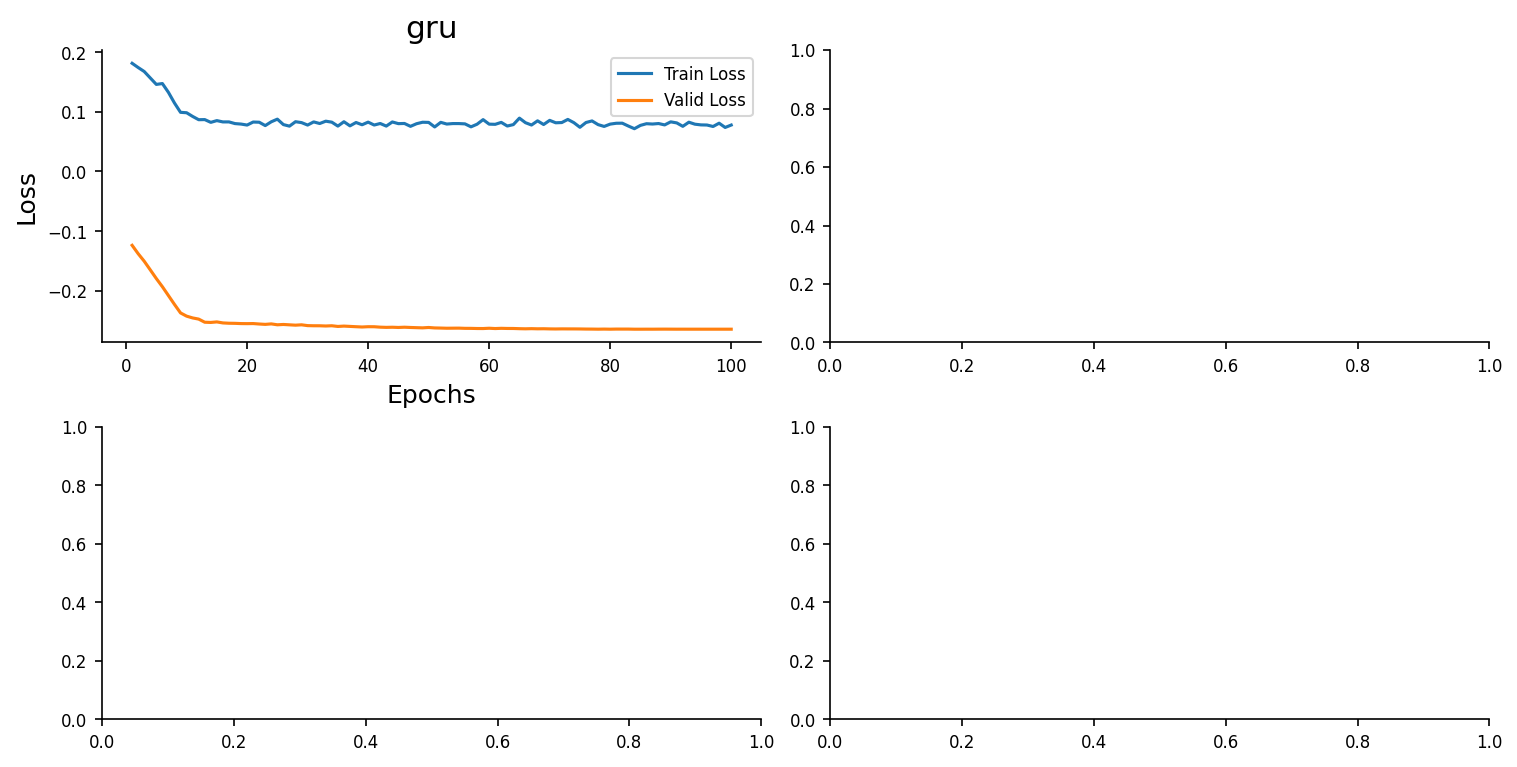

Starting training model: gru_aa
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Model checkpoint is already existed. Will be overwritten


  1%|          | 1/100 [00:03<05:58,  3.62s/it]

Epoch 1 : loss enhanced with -0.1287198528647423
Epoch: [1/100] | Training loss: 0.183 | Validiation loss: -0.129 | Time per epoch: 3.62 seconds


  2%|▏         | 2/100 [00:06<05:24,  3.31s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 2 : loss enhanced with -0.14258637949824335


  3%|▎         | 3/100 [00:09<04:42,  2.92s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 3 : loss enhanced with -0.15674065202474596


  4%|▍         | 4/100 [00:11<04:20,  2.72s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 4 : loss enhanced with -0.17140592560172083


  5%|▌         | 5/100 [00:13<04:06,  2.59s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 5 : loss enhanced with -0.1867908790707588


  6%|▌         | 6/100 [00:16<03:59,  2.54s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 6 : loss enhanced with -0.20386719554662705


  7%|▋         | 7/100 [00:19<04:16,  2.76s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 7 : loss enhanced with -0.2224932387471199


  8%|▊         | 8/100 [00:22<04:24,  2.88s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 8 : loss enhanced with -0.238923542201519


  9%|▉         | 9/100 [00:25<04:11,  2.76s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 9 : loss enhanced with -0.24729094654321673


 10%|█         | 10/100 [00:27<04:02,  2.69s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 10 : loss enhanced with -0.2510408997535706


 11%|█         | 11/100 [00:30<04:01,  2.72s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 11 : loss enhanced with -0.25178628861904145
Epoch: [11/100] | Training loss: 0.083 | Validiation loss: -0.252 | Time per epoch: 2.77 seconds


 13%|█▎        | 13/100 [00:37<04:33,  3.15s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 13 : loss enhanced with -0.2533261954784393


 14%|█▍        | 14/100 [00:40<04:25,  3.08s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 14 : loss enhanced with -0.25359333753585817


 15%|█▌        | 15/100 [00:43<04:15,  3.01s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 15 : loss enhanced with -0.25430128872394564


 16%|█▌        | 16/100 [00:46<04:07,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 16 : loss enhanced with -0.2546109825372696


 17%|█▋        | 17/100 [00:49<04:13,  3.06s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 17 : loss enhanced with -0.25491726994514463


 18%|█▊        | 18/100 [00:53<04:26,  3.25s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 18 : loss enhanced with -0.2552737474441528


 20%|██        | 20/100 [00:58<04:02,  3.03s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 20 : loss enhanced with -0.25596951842308047


 21%|██        | 21/100 [01:01<03:52,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 21 : loss enhanced with -0.25685529708862304
Epoch: [21/100] | Training loss: 0.079 | Validiation loss: -0.257 | Time per epoch: 2.74 seconds


 23%|██▎       | 23/100 [01:08<04:10,  3.26s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 23 : loss enhanced with -0.25706957280635834


 25%|██▌       | 25/100 [01:14<03:48,  3.05s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 25 : loss enhanced with -0.2574163854122162


 26%|██▌       | 26/100 [01:16<03:37,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 26 : loss enhanced with -0.25818963944911955


 27%|██▋       | 27/100 [01:19<03:32,  2.91s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 27 : loss enhanced with -0.25851532220840456


 28%|██▊       | 28/100 [01:23<03:51,  3.21s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 28 : loss enhanced with -0.25866114199161533


 29%|██▉       | 29/100 [01:27<03:51,  3.26s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 29 : loss enhanced with -0.2593829691410065


 30%|███       | 30/100 [01:29<03:35,  3.08s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 30 : loss enhanced with -0.2595207244157791


 31%|███       | 31/100 [01:32<03:24,  2.96s/it]

Epoch: [31/100] | Training loss: 0.078 | Validiation loss: -0.259 | Time per epoch: 2.68 seconds


 32%|███▏      | 32/100 [01:35<03:15,  2.88s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 32 : loss enhanced with -0.2601854711771011


 34%|███▍      | 34/100 [01:42<03:31,  3.20s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 34 : loss enhanced with -0.26042726039886477


 36%|███▌      | 36/100 [01:47<03:10,  2.97s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 36 : loss enhanced with -0.261027655005455


 37%|███▋      | 37/100 [01:50<03:01,  2.89s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 37 : loss enhanced with -0.26135388016700745


 40%|████      | 40/100 [01:59<03:03,  3.05s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 40 : loss enhanced with -0.2616270512342453


 41%|████      | 41/100 [02:02<02:56,  2.98s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 41 : loss enhanced with -0.26204213201999665
Epoch: [41/100] | Training loss: 0.074 | Validiation loss: -0.262 | Time per epoch: 2.82 seconds


 44%|████▍     | 44/100 [02:12<02:56,  3.16s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 44 : loss enhanced with -0.2627476453781128


 46%|████▌     | 46/100 [02:17<02:39,  2.95s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 46 : loss enhanced with -0.26277907490730285


 48%|████▊     | 48/100 [02:23<02:33,  2.96s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 48 : loss enhanced with -0.263192617893219


 49%|████▉     | 49/100 [02:27<02:42,  3.19s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 49 : loss enhanced with -0.2636310964822769


 51%|█████     | 51/100 [02:33<02:27,  3.02s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 51 : loss enhanced with -0.26393755674362185
Epoch: [51/100] | Training loss: 0.083 | Validiation loss: -0.264 | Time per epoch: 2.73 seconds


 53%|█████▎    | 53/100 [02:38<02:15,  2.88s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 53 : loss enhanced with -0.26414512693881986


 58%|█████▊    | 58/100 [02:53<01:57,  2.80s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 58 : loss enhanced with -0.26420474648475645


 59%|█████▉    | 59/100 [02:56<02:03,  3.00s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 59 : loss enhanced with -0.2646006137132645


 61%|██████    | 61/100 [03:03<01:58,  3.04s/it]

Epoch: [61/100] | Training loss: 0.081 | Validiation loss: -0.264 | Time per epoch: 2.69 seconds


 62%|██████▏   | 62/100 [03:05<01:51,  2.93s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 62 : loss enhanced with -0.2648778259754181


 65%|██████▌   | 65/100 [03:15<01:51,  3.18s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 65 : loss enhanced with -0.26493993401527405


 66%|██████▌   | 66/100 [03:18<01:45,  3.10s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 66 : loss enhanced with -0.2651835411787033


 67%|██████▋   | 67/100 [03:21<01:38,  2.99s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 67 : loss enhanced with -0.26523407399654386


 71%|███████   | 71/100 [03:33<01:30,  3.14s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 71 : loss enhanced with -0.2653369277715683
Epoch: [71/100] | Training loss: 0.080 | Validiation loss: -0.265 | Time per epoch: 3.14 seconds


 72%|███████▏  | 72/100 [03:36<01:24,  3.02s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 72 : loss enhanced with -0.26542033851146696


 74%|███████▍  | 74/100 [03:41<01:14,  2.88s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 74 : loss enhanced with -0.2655882775783539


 78%|███████▊  | 78/100 [03:54<01:05,  2.97s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 78 : loss enhanced with -0.26564799845218656


 81%|████████  | 81/100 [04:03<01:00,  3.18s/it]

Epoch: [81/100] | Training loss: 0.082 | Validiation loss: -0.266 | Time per epoch: 3.43 seconds


 82%|████████▏ | 82/100 [04:06<00:54,  3.04s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 82 : loss enhanced with -0.2656697750091553


 83%|████████▎ | 83/100 [04:09<00:50,  2.94s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 83 : loss enhanced with -0.26572280526161196


 87%|████████▋ | 87/100 [04:21<00:40,  3.08s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 87 : loss enhanced with -0.26575489044189454


 88%|████████▊ | 88/100 [04:24<00:35,  2.96s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 88 : loss enhanced with -0.2658033937215805


 91%|█████████ | 91/100 [04:34<00:29,  3.26s/it]

Epoch: [91/100] | Training loss: 0.081 | Validiation loss: -0.266 | Time per epoch: 3.83 seconds


100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


Total training times: 5.00 minutes
Starting training model: tcn
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Model checkpoint is already existed. Will be overwritten


  1%|          | 1/100 [00:13<22:03, 13.37s/it]

Epoch 1 : loss enhanced with -0.1258205369114876
Epoch: [1/100] | Training loss: 0.188 | Validiation loss: -0.126 | Time per epoch: 13.37 seconds


  2%|▏         | 2/100 [00:23<18:15, 11.18s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 2 : loss enhanced with -0.15494908429682255


  3%|▎         | 3/100 [00:32<16:33, 10.24s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 3 : loss enhanced with -0.1856536112725735


  4%|▍         | 4/100 [00:41<15:39,  9.79s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 4 : loss enhanced with -0.20623763501644135


  5%|▌         | 5/100 [00:50<15:20,  9.69s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 5 : loss enhanced with -0.21718282997608185


  6%|▌         | 6/100 [00:59<14:32,  9.28s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 6 : loss enhanced with -0.23080733269453052


  7%|▋         | 7/100 [01:09<14:39,  9.46s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 7 : loss enhanced with -0.24006357789039612


  8%|▊         | 8/100 [01:18<14:15,  9.30s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 8 : loss enhanced with -0.2430243596434593


  9%|▉         | 9/100 [01:27<14:24,  9.50s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 9 : loss enhanced with -0.24503813087940216


 10%|█         | 10/100 [01:37<14:25,  9.61s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 10 : loss enhanced with -0.24549503922462465


 11%|█         | 11/100 [01:46<13:54,  9.37s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 11 : loss enhanced with -0.24814684689044952
Epoch: [11/100] | Training loss: 0.078 | Validiation loss: -0.248 | Time per epoch: 8.82 seconds


 13%|█▎        | 13/100 [02:05<13:37,  9.40s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 13 : loss enhanced with -0.25045102536678315


 15%|█▌        | 15/100 [02:25<13:37,  9.61s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 15 : loss enhanced with -0.25074889659881594


 16%|█▌        | 16/100 [02:33<13:02,  9.31s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 16 : loss enhanced with -0.25148239731788635


 17%|█▋        | 17/100 [02:43<13:12,  9.54s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 17 : loss enhanced with -0.2524851679801941


 19%|█▉        | 19/100 [03:02<12:42,  9.41s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 19 : loss enhanced with -0.2532018393278122


 20%|██        | 20/100 [03:12<12:46,  9.59s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 20 : loss enhanced with -0.25446186661720277


 21%|██        | 21/100 [03:21<12:16,  9.32s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 21 : loss enhanced with -0.25542605519294737
Epoch: [21/100] | Training loss: 0.077 | Validiation loss: -0.255 | Time per epoch: 8.70 seconds


 22%|██▏       | 22/100 [03:30<12:20,  9.49s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 22 : loss enhanced with -0.25607850253582


 23%|██▎       | 23/100 [03:40<12:07,  9.45s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 23 : loss enhanced with -0.2561323672533035


 24%|██▍       | 24/100 [03:49<11:53,  9.39s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 24 : loss enhanced with -0.2561501324176788


 25%|██▌       | 25/100 [03:59<11:55,  9.54s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 25 : loss enhanced with -0.2567616432905197


 26%|██▌       | 26/100 [04:08<11:28,  9.31s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 26 : loss enhanced with -0.2581640034914017


 28%|██▊       | 28/100 [04:27<11:23,  9.50s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 28 : loss enhanced with -0.2586174964904785


 29%|██▉       | 29/100 [04:36<11:08,  9.41s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 29 : loss enhanced with -0.2588075876235962


 30%|███       | 30/100 [04:46<11:11,  9.59s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 30 : loss enhanced with -0.26031923294067383


 31%|███       | 31/100 [04:55<10:49,  9.41s/it]

Epoch: [31/100] | Training loss: 0.074 | Validiation loss: -0.259 | Time per epoch: 8.98 seconds


 32%|███▏      | 32/100 [05:05<10:46,  9.51s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 32 : loss enhanced with -0.2603736281394958


 34%|███▍      | 34/100 [05:24<10:15,  9.33s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 34 : loss enhanced with -0.26125192046165463


 35%|███▌      | 35/100 [05:33<10:15,  9.47s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 35 : loss enhanced with -0.2613347709178924


 38%|███▊      | 38/100 [06:02<09:53,  9.57s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 38 : loss enhanced with -0.2620589375495911


 39%|███▉      | 39/100 [06:11<09:29,  9.33s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 39 : loss enhanced with -0.2625910252332687


 40%|████      | 40/100 [06:21<09:29,  9.50s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 40 : loss enhanced with -0.2628207325935364


 41%|████      | 41/100 [06:30<09:18,  9.46s/it]

Epoch: [41/100] | Training loss: 0.080 | Validiation loss: -0.263 | Time per epoch: 9.38 seconds


 43%|████▎     | 43/100 [06:49<09:09,  9.64s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 43 : loss enhanced with -0.2639898508787155


 45%|████▌     | 45/100 [07:08<08:44,  9.53s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 45 : loss enhanced with -0.26414271295070646


 47%|████▋     | 47/100 [07:27<08:19,  9.43s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 47 : loss enhanced with -0.2644509196281433


 50%|█████     | 50/100 [07:55<07:55,  9.51s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 50 : loss enhanced with -0.26508360505104067


 51%|█████     | 51/100 [08:05<07:45,  9.51s/it]

Epoch: [51/100] | Training loss: 0.076 | Validiation loss: -0.265 | Time per epoch: 9.51 seconds


 53%|█████▎    | 53/100 [08:24<07:34,  9.66s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 53 : loss enhanced with -0.2654525190591812


 56%|█████▌    | 56/100 [08:53<07:03,  9.61s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 56 : loss enhanced with -0.26562192142009733


 57%|█████▋    | 57/100 [09:02<06:44,  9.40s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 57 : loss enhanced with -0.265846973657608


 59%|█████▉    | 59/100 [09:21<06:25,  9.40s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 59 : loss enhanced with -0.26619834005832677


 61%|██████    | 61/100 [09:40<06:14,  9.59s/it]

Epoch: [61/100] | Training loss: 0.079 | Validiation loss: -0.266 | Time per epoch: 9.73 seconds


 62%|██████▏   | 62/100 [09:49<05:56,  9.38s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 62 : loss enhanced with -0.2662586122751236


 63%|██████▎   | 63/100 [09:59<05:52,  9.54s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 63 : loss enhanced with -0.26636399924755094


 65%|██████▌   | 65/100 [10:18<05:31,  9.46s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 65 : loss enhanced with -0.26652459502220155


 66%|██████▌   | 66/100 [10:28<05:28,  9.67s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 66 : loss enhanced with -0.26656129360198977


 67%|██████▋   | 67/100 [10:37<05:10,  9.40s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 67 : loss enhanced with -0.26679540872573854


 70%|███████   | 70/100 [11:05<04:43,  9.43s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 70 : loss enhanced with -0.26682141423225403


 71%|███████   | 71/100 [11:15<04:37,  9.58s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 71 : loss enhanced with -0.2668993055820465
Epoch: [71/100] | Training loss: 0.075 | Validiation loss: -0.267 | Time per epoch: 9.92 seconds


 72%|███████▏  | 72/100 [11:24<04:20,  9.31s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 72 : loss enhanced with -0.26701675057411195


 75%|███████▌  | 75/100 [11:53<03:55,  9.41s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 75 : loss enhanced with -0.2670494496822357


 77%|███████▋  | 77/100 [12:12<03:35,  9.38s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 77 : loss enhanced with -0.2672993361949921


 78%|███████▊  | 78/100 [12:22<03:31,  9.61s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 78 : loss enhanced with -0.26733043789863586


 81%|████████  | 81/100 [12:50<03:01,  9.56s/it]

Epoch: [81/100] | Training loss: 0.080 | Validiation loss: -0.267 | Time per epoch: 9.87 seconds


 84%|████████▍ | 84/100 [13:19<02:33,  9.57s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 84 : loss enhanced with -0.2674125522375107


 91%|█████████ | 91/100 [14:25<01:25,  9.51s/it]

Epoch: [91/100] | Training loss: 0.076 | Validiation loss: -0.267 | Time per epoch: 9.94 seconds


100%|██████████| 100/100 [15:49<00:00,  9.50s/it]


Total training times: 15.83 minutes
Starting training model: transformer
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Model checkpoint is already existed. Will be overwritten


  1%|          | 1/100 [00:05<08:56,  5.42s/it]

Epoch 1 : loss enhanced with -0.2384001225233078
Epoch: [1/100] | Training loss: 0.185 | Validiation loss: -0.238 | Time per epoch: 5.42 seconds


  2%|▏         | 2/100 [00:09<07:14,  4.43s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 2 : loss enhanced with -0.2501268297433853


  3%|▎         | 3/100 [00:12<06:38,  4.11s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 3 : loss enhanced with -0.2649095728993416


  4%|▍         | 4/100 [00:16<06:33,  4.10s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 4 : loss enhanced with -0.2738626569509506


  5%|▌         | 5/100 [00:22<07:05,  4.48s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 5 : loss enhanced with -0.2761763274669647


  6%|▌         | 6/100 [00:25<06:38,  4.24s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 6 : loss enhanced with -0.27686057090759275


  7%|▋         | 7/100 [00:29<06:21,  4.10s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 7 : loss enhanced with -0.27869676649570463


  8%|▊         | 8/100 [00:34<06:37,  4.32s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 8 : loss enhanced with -0.2792722105979919


  9%|▉         | 9/100 [00:39<06:42,  4.42s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 9 : loss enhanced with -0.2800853908061981


 10%|█         | 10/100 [00:42<06:21,  4.24s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 10 : loss enhanced with -0.2809572011232376


 11%|█         | 11/100 [00:46<06:04,  4.10s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 11 : loss enhanced with -0.2821673691272736
Epoch: [11/100] | Training loss: 0.082 | Validiation loss: -0.282 | Time per epoch: 3.77 seconds


 12%|█▏        | 12/100 [00:52<06:32,  4.46s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 12 : loss enhanced with -0.28262598514556886


 13%|█▎        | 13/100 [00:56<06:19,  4.36s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 13 : loss enhanced with -0.2835700303316116


 14%|█▍        | 14/100 [01:00<06:04,  4.23s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 14 : loss enhanced with -0.28376999497413635


 15%|█▌        | 15/100 [01:04<06:01,  4.26s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 15 : loss enhanced with -0.28460927009582515


 16%|█▌        | 16/100 [01:09<06:15,  4.47s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 16 : loss enhanced with -0.2852289915084839


 17%|█▋        | 17/100 [01:13<05:56,  4.30s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 17 : loss enhanced with -0.28594246506690985


 18%|█▊        | 18/100 [01:17<05:38,  4.13s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 18 : loss enhanced with -0.28673509061336516


 19%|█▉        | 19/100 [01:21<05:49,  4.31s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 19 : loss enhanced with -0.28686089217662813


 20%|██        | 20/100 [01:26<05:52,  4.40s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 20 : loss enhanced with -0.28735207617282865


 21%|██        | 21/100 [01:30<05:37,  4.27s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 21 : loss enhanced with -0.287582728266716
Epoch: [21/100] | Training loss: 0.081 | Validiation loss: -0.288 | Time per epoch: 3.97 seconds


 23%|██▎       | 23/100 [01:39<05:50,  4.55s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 23 : loss enhanced with -0.28791476786136627


 24%|██▍       | 24/100 [01:43<05:33,  4.38s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 24 : loss enhanced with -0.28841414451599123


 25%|██▌       | 25/100 [01:47<05:17,  4.24s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 25 : loss enhanced with -0.2884468287229538


 26%|██▌       | 26/100 [01:52<05:20,  4.33s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 26 : loss enhanced with -0.2886987119913101


 27%|██▋       | 27/100 [01:56<05:26,  4.48s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 27 : loss enhanced with -0.28902291357517246


 29%|██▉       | 29/100 [02:04<04:58,  4.20s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 29 : loss enhanced with -0.2893469870090485


 30%|███       | 30/100 [02:10<05:16,  4.52s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 30 : loss enhanced with -0.28954517245292666


 31%|███       | 31/100 [02:14<05:09,  4.49s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 31 : loss enhanced with -0.2898890018463135
Epoch: [31/100] | Training loss: 0.078 | Validiation loss: -0.290 | Time per epoch: 4.42 seconds


 33%|███▎      | 33/100 [02:22<04:46,  4.28s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 33 : loss enhanced with -0.29035045206546783


 35%|███▌      | 35/100 [02:31<04:45,  4.40s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 35 : loss enhanced with -0.29046864807605743


 37%|███▋      | 37/100 [02:40<04:38,  4.43s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 37 : loss enhanced with -0.29054713249206543


 38%|███▊      | 38/100 [02:45<04:35,  4.45s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 38 : loss enhanced with -0.29084090888500214


 40%|████      | 40/100 [02:52<04:08,  4.15s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 40 : loss enhanced with -0.29099826514720917


 41%|████      | 41/100 [02:58<04:24,  4.48s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 41 : loss enhanced with -0.29133751988410944
Epoch: [41/100] | Training loss: 0.077 | Validiation loss: -0.291 | Time per epoch: 5.25 seconds


 42%|████▏     | 42/100 [03:02<04:10,  4.32s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 42 : loss enhanced with -0.29142391085624697


 43%|████▎     | 43/100 [03:05<03:58,  4.18s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 43 : loss enhanced with -0.2914314389228821


 44%|████▍     | 44/100 [03:10<04:00,  4.29s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 44 : loss enhanced with -0.2917341232299805


 45%|████▌     | 45/100 [03:15<04:04,  4.45s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 45 : loss enhanced with -0.2917816460132599


 47%|████▋     | 47/100 [03:22<03:38,  4.13s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 47 : loss enhanced with -0.29195610880851747


 49%|████▉     | 49/100 [03:32<03:42,  4.36s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 49 : loss enhanced with -0.29208514988422396


 50%|█████     | 50/100 [03:36<03:32,  4.24s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 50 : loss enhanced with -0.2922499299049377


 51%|█████     | 51/100 [03:40<03:26,  4.21s/it]

Epoch: [51/100] | Training loss: 0.075 | Validiation loss: -0.292 | Time per epoch: 4.12 seconds


 52%|█████▏    | 52/100 [03:45<03:36,  4.51s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 52 : loss enhanced with -0.29226604104042053


 54%|█████▍    | 54/100 [03:53<03:12,  4.18s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 54 : loss enhanced with -0.2922907829284668


 55%|█████▌    | 55/100 [03:57<03:13,  4.30s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 55 : loss enhanced with -0.29237247705459596


 56%|█████▌    | 56/100 [04:02<03:17,  4.49s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 56 : loss enhanced with -0.2924102544784546


 57%|█████▋    | 57/100 [04:06<03:06,  4.34s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 57 : loss enhanced with -0.2924518406391144


 58%|█████▊    | 58/100 [04:10<02:56,  4.20s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 58 : loss enhanced with -0.29260050952434535


 61%|██████    | 61/100 [04:24<02:46,  4.28s/it]

Epoch: [61/100] | Training loss: 0.074 | Validiation loss: -0.293 | Time per epoch: 3.91 seconds


 62%|██████▏   | 62/100 [04:28<02:43,  4.30s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 62 : loss enhanced with -0.2926093250513077


 63%|██████▎   | 63/100 [04:33<02:47,  4.53s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 63 : loss enhanced with -0.2926904082298279


 64%|██████▍   | 64/100 [04:37<02:36,  4.35s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 64 : loss enhanced with -0.2927553832530976


 65%|██████▌   | 65/100 [04:41<02:28,  4.25s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 65 : loss enhanced with -0.2927952885627747


 67%|██████▋   | 67/100 [04:50<02:25,  4.41s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 67 : loss enhanced with -0.2928607821464539


 68%|██████▊   | 68/100 [04:54<02:16,  4.26s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 68 : loss enhanced with -0.29286459684371946


 69%|██████▉   | 69/100 [04:58<02:11,  4.26s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 69 : loss enhanced with -0.29292435944080353


 71%|███████   | 71/100 [05:07<02:05,  4.32s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 71 : loss enhanced with -0.29296556711196897
Epoch: [71/100] | Training loss: 0.078 | Validiation loss: -0.293 | Time per epoch: 3.84 seconds


 72%|███████▏  | 72/100 [05:11<01:58,  4.24s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 72 : loss enhanced with -0.29301467537879944


 74%|███████▍  | 74/100 [05:21<01:56,  4.47s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 74 : loss enhanced with -0.2930641174316406


 76%|███████▌  | 76/100 [05:29<01:40,  4.20s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 76 : loss enhanced with -0.29306990206241607


 78%|███████▊  | 78/100 [05:38<01:37,  4.43s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 78 : loss enhanced with -0.293104875087738


 79%|███████▉  | 79/100 [05:42<01:29,  4.28s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 79 : loss enhanced with -0.29312803149223327


 80%|████████  | 80/100 [05:47<01:26,  4.32s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 80 : loss enhanced with -0.2931606948375702


 81%|████████  | 81/100 [05:52<01:26,  4.54s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 81 : loss enhanced with -0.2931721270084381
Epoch: [81/100] | Training loss: 0.072 | Validiation loss: -0.293 | Time per epoch: 5.05 seconds


 83%|████████▎ | 83/100 [05:59<01:11,  4.20s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 83 : loss enhanced with -0.29318391978740693


 84%|████████▍ | 84/100 [06:04<01:11,  4.47s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 84 : loss enhanced with -0.29318618178367617


 85%|████████▌ | 85/100 [06:09<01:06,  4.44s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 85 : loss enhanced with -0.29319950342178347


 87%|████████▋ | 87/100 [06:17<00:56,  4.32s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 87 : loss enhanced with -0.2932015359401703


 89%|████████▉ | 89/100 [06:26<00:47,  4.35s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 89 : loss enhanced with -0.29322010576725005


 91%|█████████ | 91/100 [06:35<00:40,  4.47s/it]

Epoch: [91/100] | Training loss: 0.075 | Validiation loss: -0.293 | Time per epoch: 4.97 seconds


 92%|█████████▏| 92/100 [06:40<00:35,  4.46s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 92 : loss enhanced with -0.2932238698005676


 94%|█████████▍| 94/100 [06:48<00:25,  4.21s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 94 : loss enhanced with -0.2932284325361252


 95%|█████████▌| 95/100 [06:53<00:22,  4.56s/it]

Model checkpoint is already existed. Will be overwritten
Epoch 95 : loss enhanced with -0.29323022067546844


100%|██████████| 100/100 [07:14<00:00,  4.34s/it]

Total training times: 7.23 minutes


In [31]:
runtime_all = {}
visualize = True
rows = math.ceil(len(model_names)/2.0)
fig, axes = plt.subplots(rows, 2, figsize = (10, 5))

for idx, name in enumerate(model_names):
  print(f'Starting training model: {name}')
  print("-"*50)
  model, train_loss, valid_loss, runtime = train_model(name, constraint_allocation=True)
  runtime_all[name] = runtime

  if visualize:
    ax = axes.flatten()[idx]
    ax.plot(range(1, len(train_loss)+1), train_loss, label='Train Loss')
    ax.plot(range(1, len(valid_loss)+1), valid_loss, label='Valid Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(name)
    ax.legend()
    if idx == len(model_names):
      fig.suptitle('Train and valid loss for each model')
    plt.show()

### **Running Time Plot**

In [53]:
pd.DataFrame(list(runtime_all.items()), columns = ['Models', 'Time'])

,Models,Time
0,gru,284.346405
1,gru_aa,300.045705
2,tcn,949.602899
3,transformer,434.086365


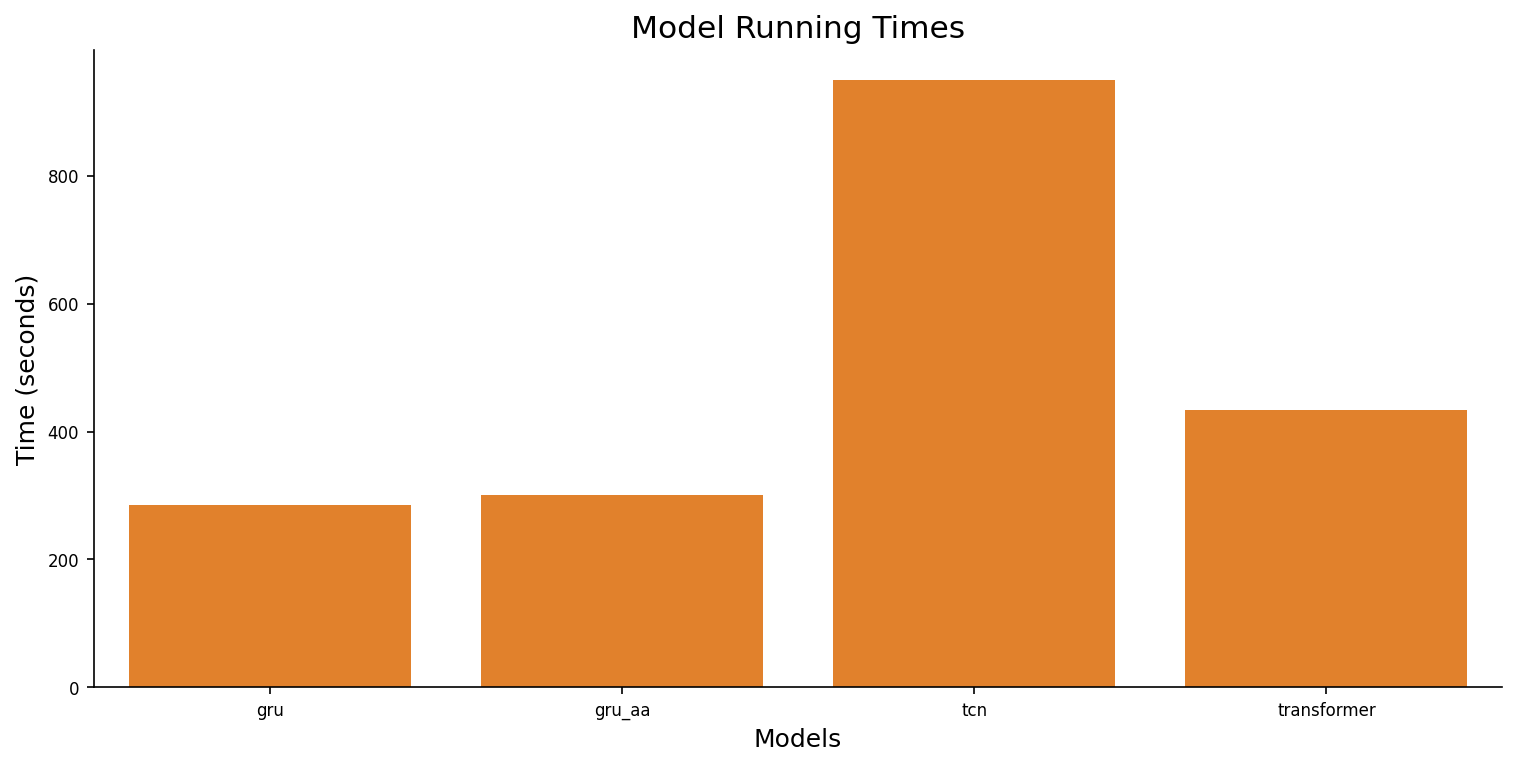

In [55]:
# Convert the dictionary to a DataFrame
df_runtime = pd.DataFrame(list(runtime_all.items()), columns=['Models', 'Time'])

# Create the barplot
plt.figure(figsize=(10,5))
sns.barplot(x='Models', y='Time', data=df_runtime, color='tab:orange')

# Set labels and title
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Model Running Times')
plt.show()

## **Backtesting**

In [33]:
def compute_mdd(portfolio_values):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio_values)
    # Ensure the value never drops below 1
    running_max[running_max < 10000] = 10000
    # Calculate the drawdown
    drawdown = (portfolio_values / running_max) - 1
    # Return the minimum (i.e., the maximum drawdown)
    return drawdown.min()

def backtest_models(models, names, checkpoint_path, test_data, test_target, times_te, config, device):
    # Initialize dictionaries to store the weights and portfolios for each model
    model_weights = {}
    model_portfolios = {}

    # Initialize a list to store the equal weight portfolio
    equal_portfolio = [10000]
    equal_weights = np.ones(config['N_FEAT']) / config['N_FEAT']

    for model, model_name in zip(models, names):
        # Load the model
        model = load_model(model, checkpoint_path, model_name)

        # Initialize a list to store the weights for model
        weights = []
        # Initialize a list to store the portfolio for model
        portfolio = [10000]

        for i in range(0, x_te_np.shape[0], config["LEN_PRED"]):
            x = x_te_np[i][np.newaxis, :, :]
            out = model(x.float().to(device))[0]
            weights.append(out.detach().cpu().numpy())
            m_rtn = np.sum(y_te[i], axis=0)
            portfolio.append(
                portfolio[-1] * np.exp(np.dot(out.detach().cpu().numpy(), m_rtn))
            )
            if model_name == names[0]:  # Only calculate the equal weight portfolio for the first model
                equal_portfolio.append(
                    equal_portfolio[-1] * np.exp(np.dot(equal_weights, m_rtn))
                )


        # Store the weights and portfolio for this model
        model_weights[model_name] = weights
        model_portfolios[model_name] = portfolio

    # Get the time indices
    idx = np.arange(0, len(times_te), 11)
    model_portfolios['date'] = pd.to_datetime(times_te, unit = 'ns')[idx]
    model_portfolios['EWP'] = equal_portfolio

    return model_weights, model_portfolios

In [34]:
deep_weights, deep_portfolios = backtest_models(model_list, model_names, checkpoint_path,
                                 x_te_np, y_te, times_te_np, config, device)

In [35]:
def compute_metrics(performance):
    # Initialize a dictionary to store the results
    results = {}

    # Loop over each column in the performance DataFrame
    for column in performance.columns:
        # Copy the performance DataFrame
        result = performance.copy()

        # Calculate the return for this column
        result[column + "_Return"] = np.log(result[column]) - np.log(result[column].shift(1))
        result = result.dropna()

        # Calculate the expected return
        expected_return = result[column + "_Return"].mean() * 12

        # Calculate the volatility
        volatility = result[column + "_Return"].std() * np.sqrt(12)

        # Calculate the Sharpe ratio
        sharpe_ratio = expected_return / volatility

        # Calculate the maximum drawdown
        mdd = compute_mdd(result[column])

        # Store the results
        results[column] = {
            'Annualized Return': expected_return,
            'Annualized Volatility': volatility,
            'Annualized Sharpe Ratio': sharpe_ratio,
            'MDD': mdd
        }

    # Convert the results dictionary to a DataFrame
    results_df = pd.DataFrame(results).T

    return results_df

In [36]:
performance = pd.DataFrame(deep_portfolios).set_index('date')
result = compute_metrics(performance).sort_values(by=['Annualized Sharpe Ratio', 'Annualized Return'], ascending = False)

In [37]:
result

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,MDD
transformer,0.244653,0.151027,1.619927,-0.091208
gru,0.236020,0.146930,1.606348,-0.088450
gru_aa,0.236281,0.147458,1.602359,-0.088901
tcn,0.235084,0.147923,1.589231,-0.090269
EWP,0.173883,0.132535,1.311977,-0.093141


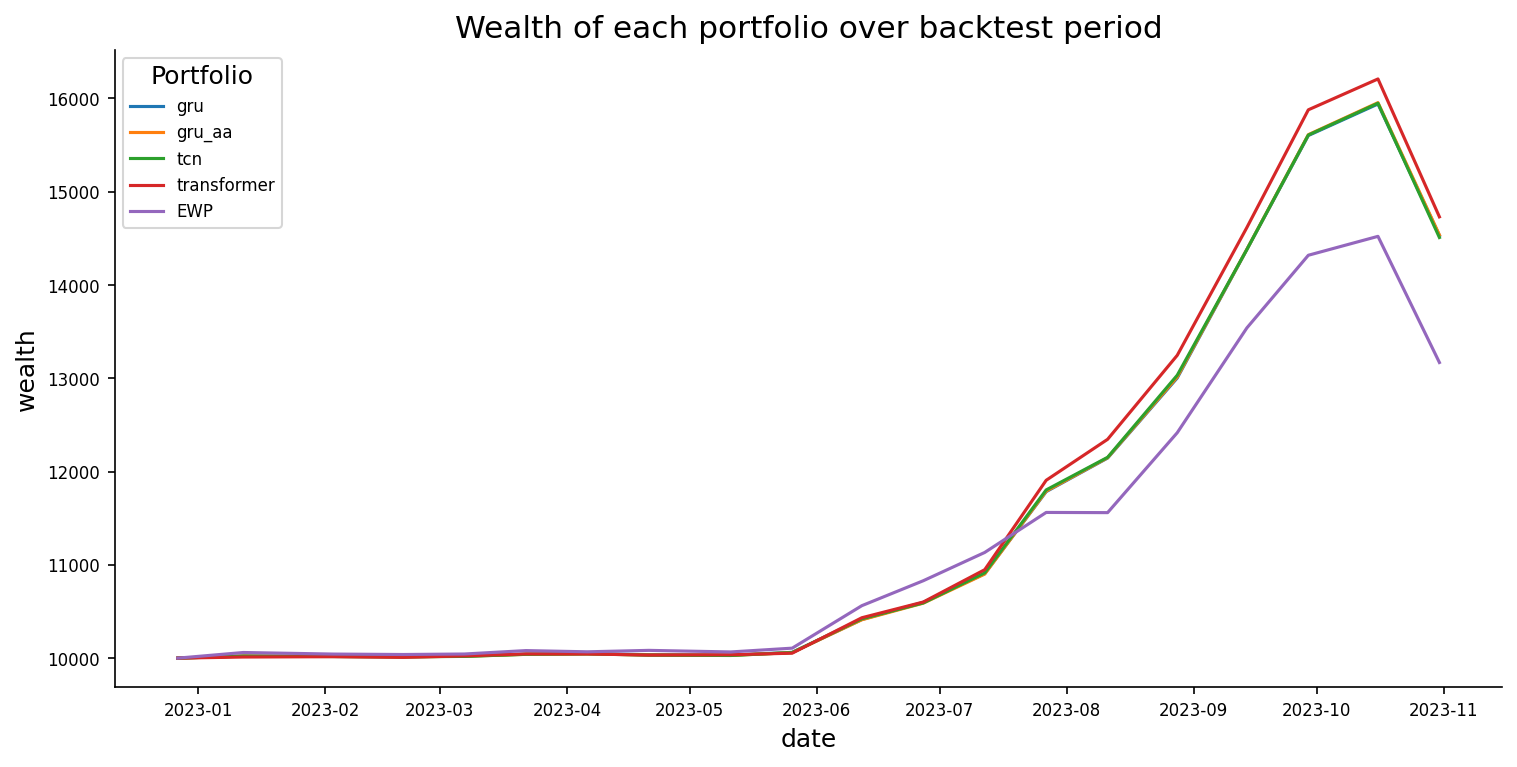

In [47]:
import seaborn as sns
# Melt the DataFrame to make it suitable for sns.lineplot
performance_melted = performance.reset_index().melt('date', var_name='portfolio', value_name='wealth')

# Create the lineplot
plt.figure(figsize=(10,5))
sns.lineplot(data=performance_melted, x='date', y='wealth', hue='portfolio')

# Add title and legend
plt.title('Wealth of each portfolio over backtest period')
plt.legend(title='Portfolio')
plt.show()